# Interpolasi Kriging 3 Dimensi

In [1]:
import numpy as np
import pandas as pd
import gstools as gs
from pathlib import Path
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider, IntSlider
from scipy.interpolate import griddata
from pykrige.uk3d import UniversalKriging3D

In [2]:
# 1. Baca data CSV
data = pd.read_csv("/Users/yudhastyawan/Documents/data/coulomb_test.csv")

# 2. Ekstrak koordinat dan nilai
x = data.iloc[:,0].values
y = data.iloc[:,1].values
depth_columns = data.columns[2:]  # Kolom kedalaman
depths = np.arange(0, 21, 2)     # 0,2,4,...,20 km

In [30]:
iloc = np.logical_and(np.in1d(x, np.unique(x)[::4]), np.in1d(y, np.unique(y)[::4]))
x_u = x[iloc]
y_u = y[iloc]
values = data.iloc[iloc,2:].values.clip(min=-1, max=1)
v_u = values[:,::3]
d_u = depths[::3]; d_u

array([ 0.,  6., 12., 18.])

In [31]:
# 3. Bentuk data 3D
xx, yy, zz = np.meshgrid(np.unique(x_u), np.unique(y_u), d_u, indexing='ij')
vv = v_u.reshape(len(np.unique(x_u)), len(np.unique(y_u)), len(d_u)); vv.shape

(32, 33, 4)

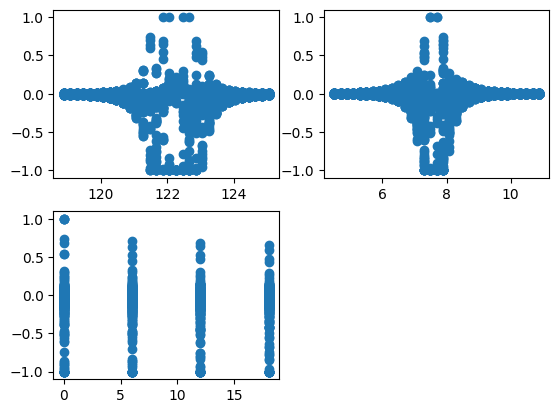

In [32]:
plt.subplot(221)
plt.scatter(xx.flatten(), vv.flatten())
plt.subplot(222)
plt.scatter(yy.flatten(), vv.flatten())
plt.subplot(223)
plt.scatter(zz.flatten(), vv.flatten())

In [6]:
@interact
def im_show(value=IntSlider(min=0, max=(len(d_u)-1), value=0)):
    print(d_u[value])
    plt.imshow(vv[:,:,value], cmap="bwr", vmin=-1, vmax=1)

interactive(children=(IntSlider(value=0, description='value', max=3), Output()), _dom_classes=('widget-interac…

/Users/yudhastyawan/miniconda3-arm/envs/pydask/lib/python3.10/site-packages/gstools/covmodel/plot.py:122: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


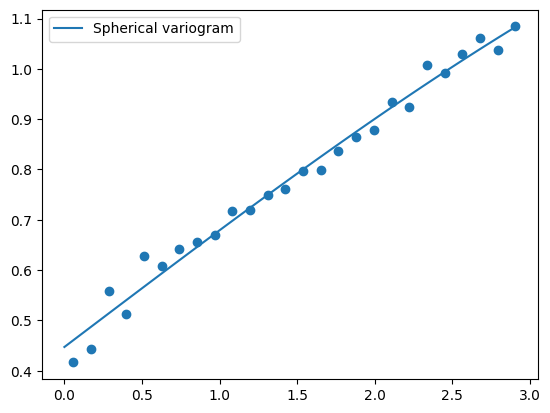

Spherical(dim=3, var=1.03, len_scale=6.64, nugget=0.447)


In [7]:
# 2. Variogram empiris dengan fungsi terbaru
model = gs.Spherical(dim=3)
bin_center, gamma = gs.vario_estimate(
    pos=[xx.flatten(), yy.flatten(), zz.flatten()/111.],
    field=vv.flatten(),
    # bin_edges=np.r_[0:12.0:0.25],
    # estimator="cressie",
)
model.fit_variogram(bin_center, gamma)

# output
ax = model.plot(x_max=max(bin_center))
ax.scatter(bin_center, gamma)
plt.show()
print(model)

In [8]:
uk3d = UniversalKriging3D(
    xx.flatten(),
    yy.flatten(),
    zz.flatten()/111.,
    vv.flatten(),
    variogram_model=model,
    drift_terms=["regional_linear"],
)

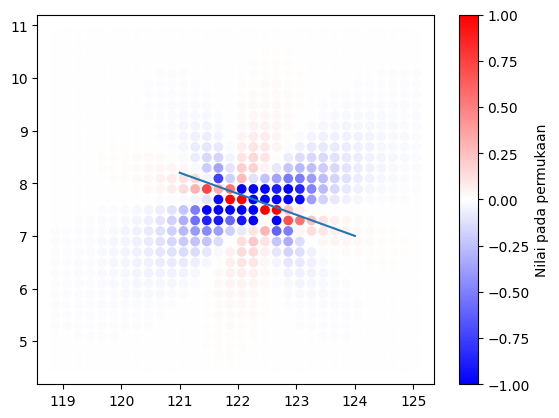

In [26]:
points = np.array([[121., 8.2], [124., 7.]])

# 5. Fungsi pemilihan titik interaktif (tetap sama seperti sebelumnya)
fig, ax = plt.subplots()
sc = ax.scatter(x_u, y_u, c=vv[...,0].flatten(), cmap='bwr', vmin=-1, vmax=1)
ax.plot(points[:,0], points[:,1])
plt.colorbar(sc, label='Nilai pada permukaan')

plt.show()

In [15]:
xx_0, yy_0 = np.meshgrid(np.unique(x)[::4], np.unique(y)[::4], indexing='ij')
k3d2, ss3d = uk3d.execute("points", xx_0.flatten(), yy_0.flatten(), np.zeros_like(xx_0.flatten())+1/111.)

In [16]:
k3d2.data

array([0.01533929, 0.01237005, 0.0105997 , ..., 0.01234027, 0.01426732,
       0.01728126])

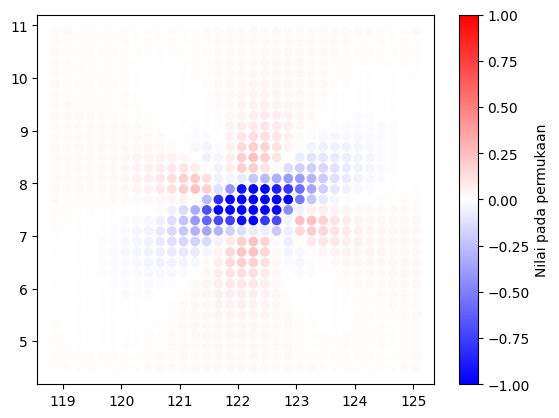

In [17]:
fig, ax = plt.subplots()
sc = ax.scatter(xx_0.flatten(), yy_0.flatten(), c=k3d2.data, cmap='bwr', vmin=-1, vmax=1)
plt.colorbar(sc, label='Nilai pada permukaan')

plt.show()

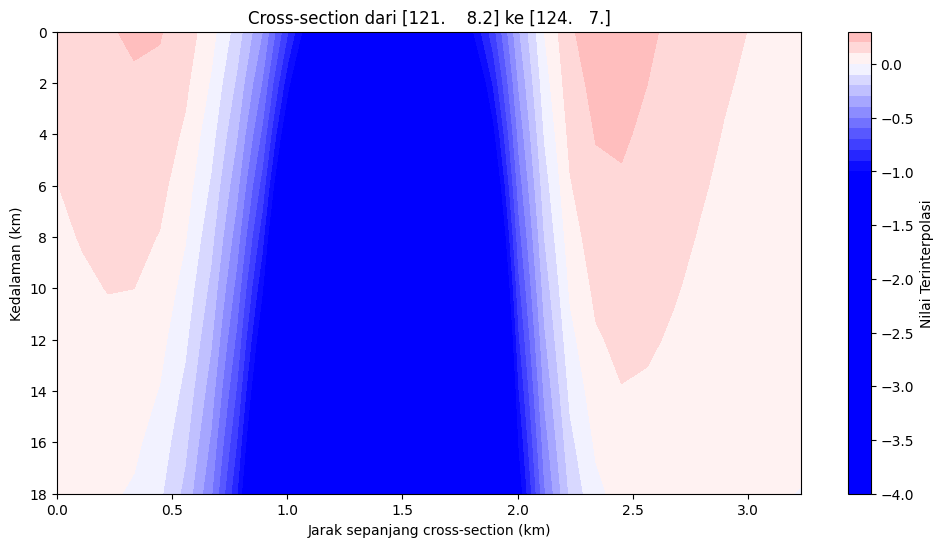

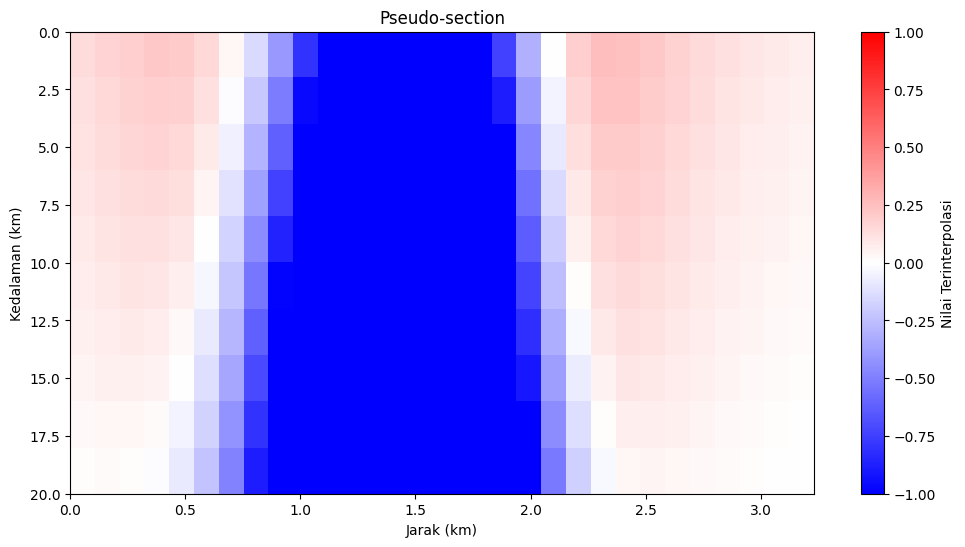

In [29]:
# 6. Fungsi pembuatan cross-section (dioptimalkan)
num_points=30
depth_levels=10
start, end = points.tolist()

# Generate titik sepanjang cross-section
line_x = np.linspace(start[0], end[0], num_points)
line_y = np.linspace(start[1], end[1], num_points)
depths = np.linspace(0, 18, depth_levels)

# Membuat grid 2D untuk interpolasi
xx, zz = np.meshgrid(line_x, depths, indexing='ij')
yy, _ = np.meshgrid(line_y, depths, indexing='ij')
coords = np.vstack((xx.flatten(), yy.flatten(), zz.flatten())).T
k3d2, ss3d = uk3d.execute("points", xx.flatten(), yy.flatten(), zz.flatten()/111.)

# Hitung jarak
distance = np.sqrt((line_x - start[0])**2 + (line_y - start[1])**2)

section = k3d2.data.reshape((num_points, depth_levels)).T
sdval = ss3d.data.reshape((num_points, depth_levels)).T

# Visualisasi kontur
plt.figure(figsize=(12,6))
plt.contourf(distance, depths, section, levels=50, cmap='bwr', vmin=-1, vmax=1)
plt.colorbar(label='Nilai Terinterpolasi')
plt.xlabel('Jarak sepanjang cross-section (km)')
plt.ylabel('Kedalaman (km)')
plt.title(f'Cross-section dari {np.round(start,2)} ke {np.round(end,2)}')
plt.gca().invert_yaxis()

# Alternatif visualisasi dengan imshow
plt.figure(figsize=(12,6))
plt.imshow(section, extent=[0, distance[-1], 20, 0], 
            aspect='auto', cmap='bwr', vmin=-1, vmax=1)
plt.colorbar(label='Nilai Terinterpolasi')
plt.xlabel('Jarak (km)')
plt.ylabel('Kedalaman (km)')
plt.title('Pseudo-section')
plt.show()